<a href="https://colab.research.google.com/github/kangdy25/Python_DataAnalysis/blob/main/Unstructured_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/9

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,876 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [7]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [8]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [9]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [10]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [11]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [13]:
set_seed(86)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

2


In [14]:
set_seed(86)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The image features a book titled "Why Dogs Are Better Than Cats" by Bradley Trevor Greive, which is placed on the left side of the frame. The cover of the book prominently displays an illustration of a cat sitting atop a black dog's head, with both animals appearing content and happy. To the right of the book stands a real-life tabby cat, seemingly observing the camera with a slightly skeptical expression. The background consists of a wooden floor, providing a natural and warm setting for the scene.


## 14-5 의류 이미지 여부 판단

In [16]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'is this a picture of clothing?'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

yes
no
yes
yes
yes
no
yes
yes
no
yes
yes
yes


## 14-6 의류 판단 결과 시각화

In [17]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,False
2,,True
3,,True
4,,True
5,,False
6,,True
7,,True
8,,False
9,,True


## 14-7 의류 이미지 필터링

In [18]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

In [19]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
2,,True
3,,True
4,,True
6,,True
7,,True
9,,True
10,,True
11,,True


## 14-8 의류 스타일 분석

In [20]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipython-input-1482516394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [21]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the clothes in the image leans towards a minimalist and modern aesthetic, characterized by its simplicity and understated elegance. The dark grey color of the suit is versatile and timeless, often associated with sophistication and professionalism. This color choice can be seen across various fashion trends as it offers a neutral yet striking option that can be paired with a wide range of accessories.\n\nThe oversized blazer suggests a trend toward more relaxed and comfortable fits, which has been gaining popularity in recent years. This shift from tailored to more loose-fitting garments reflects a broader movement within contemporary fashion that prioritizes comfort alongside style. The lack of visible branding or embellishments on the clothing indicates a preference for clean lines and uncluttered design, aligning with the minimalism trend.\n\nOverall, the outfit could be categorized under contemporary men's fashion, where there is an emphasis on both form and function, with an eye for detail but without excessive ornamentation. The attire seems suitable for semi-formal occasions, office wear, or even casual outings, showcasing versatility in its use."
2,,True,"The style of the shoes depicted in the image is reminiscent of classic, casual footwear often associated with a laid-back or vintage aesthetic. The use of beige and red colors suggests a nod to retro fashion trends, which frequently incorporate such color combinations for their nostalgic appeal. These colors can evoke a sense of timelessness and could be part of a deliberate design choice to attract consumers who appreciate a blend of contemporary and vintage styles.\n\nIn terms of trend changes, this pair of shoes may reflect a resurgence of interest in sneakers that have a retro look but are still functional for everyday wear. The sturdy construction and high-top design also suggest an adaptation to modern lifestyle needs while maintaining a connection to past fashion eras. Such designs often cater to consumers looking for comfort without sacrificing style, as well as those who seek out unique and less mainstream options in the market."
3,,True,"The boots in the image are designed with a classic style that has seen consistent popularity over many decades. The suede material and the color palette suggest a preference for earthy tones, which is often associated with outdoor or rugged styles. This choice of material and color can indicate a trend towards natural materials and colors, which have been part of fashion cycles but remain timeless.\n\nThe design elements such as the sturdy construction, reinforced toe cap, and deep tread pattern on the sole point to functionality being a key consideration, likely catering to activities like hiking or walking in rough terrains where durability and grip are essential. The presence of a zipper pull tab at the back of the boot adds a practical touch, making it easier to put on and take off, which could appeal to those who value convenience without compromising on style.\n\nIn terms of current trends, these boots seem to align with a broader movement towards sustainable and ethical fashion choices, which includes using natural materials and opting for classic designs that can be worn seasonally rather than just following yearly fashion trends. The boots' timeless look suggests they could fit into various fashion contexts, from casual wear to more adventurous outfits, depending on how they are styled."
4,,True,"The style of the clothes in the image leans towards casual and streetwear fashion. The green hoodie is a classic piece that has been popular for its comfort and versatility. The presence of the word ""ARM"" on the chest suggests a possible brand or design element, which is common in contemporary urban clothing where branding often plays a significant role.\n\nThe layered look with a denim shirt underneath adds depth to the outfit and is a trend that allows for personal expressi

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [25]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

INFO 12-02 11:33:23 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 12-02 11:33:23 config.py:549] This model supports multiple tasks: {'generate', 'reward', 'score', 'classify', 'embed'}. Defaulting to 'generate'.
INFO 12-02 11:33:23 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 12-02 11:34:05 model_runner.py:1115] Loading model weights took 4.5096 GB
INFO 12-02 11:34:08 worker.py:267] Memory profiling takes 2.45 seconds
INFO 12-02 11:34:08 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 12-02 11:34:08 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.89GiB.
INFO 12-02 11:34:08 executor_base.py:111] # cuda blocks: 1647, # CPU blocks: 3495
INFO 12-02 11:34:08 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.64x
INFO 12-02 11:34:15 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:43<00:00,  1.23s/it]

INFO 12-02 11:34:59 model_runner.py:1562] Graph capturing finished in 43 secs, took 0.21 GiB
INFO 12-02 11:34:59 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 53.80 seconds


## 14-10 색상 정보 추출

In [28]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요. \n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s, est. speed input: 1118.57 toks/s, output: 20.19 toks/s]


색상: 어두운 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, est. speed input: 482.01 toks/s, output: 37.40 toks/s]


**색상:**
- 베이지 (Beige)
- 빨강 (Red)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s, est. speed input: 718.01 toks/s, output: 33.51 toks/s]


**색상:**
- 흙색 (Earthy tones)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s, est. speed input: 736.14 toks/s, output: 31.66 toks/s]


- 녹색 (Green)
- 파란색 (Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, est. speed input: 560.26 toks/s, output: 35.87 toks/s]


- 갈색 (brown)
- 검은색 (black)
- 어두운 네이비 (dark navy)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, est. speed input: 540.64 toks/s, output: 34.42 toks/s]


- **maroon**
- **gray**
- **beige**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, est. speed input: 512.50 toks/s, output: 36.30 toks/s]


- **검정색** (Black)
- **흰색** (White)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s, est. speed input: 2115.42 toks/s, output: 13.87 toks/s]


갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s, est. speed input: 824.52 toks/s, output: 28.87 toks/s]

- **검정색** (Black)



/tmp/ipython-input-1327615383.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [31]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요. \n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, est. speed input: 166.98 toks/s, output: 38.90 toks/s]


- **미니멀리즘**
- **현대적**
- **심플**
- **세련됨**
- **다크그레이**
- **실용성**
- **편안함**
- **깔끔함**
- **형태와 기능의 균형**
- **세부 디자인**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it, est. speed input: 178.96 toks/s, output: 40.53 toks/s]


- **클래식**
- **캐주얼**
- **빈티지**
- **라디칼**
- **레트로**
- **타임리스**
- **기능성**
- **현대적**
- **독특함**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, est. speed input: 187.24 toks/s, output: 39.68 toks/s]


- **클래식 스타일**
- **earth tones**
- **자연 재료**
- **기능성**
- **지지대**
- **실용성**
- **수직**
- **지속 가능성**
- **윤리적 패션**
- **시즌별 활용**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it, est. speed input: 228.50 toks/s, output: 39.03 toks/s]


- 캐주얼
- 스트리트웨어
- 클래식
- 편안함
- 다양성
- 브랜드 요소
- 믹스앤매치
- 실용성
- 트렌디
- 내구성
- 개인 표현
- 현대 캐주얼 스타일


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, est. speed input: 148.52 toks/s, output: 39.60 toks/s]


- **현대적**
- **도시 패션**
- **실용성**
- **따뜻함**
- **아웃도어**
- **도시 스트리트웨어**
- **럭셔리**
- ** sophistication**
- **디테일**
- **실용성**
- **지구 tones**
- **실용적**
- **트렌디**
- **품질**
- **텍스처**


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, est. speed input: 120.87 toks/s, output: 35.50 toks/s]


- **캐주얼**
- ** thoughtfully curated**
- **미니멀리즘**
- ** earthy**
- ** 중성적**
- ** monochromatic**
- ** 팝 오브 컬러**
- ** 조화로운 색상**
- ** 편안함**
- ** 계절적**
- ** 현대적**
- ** 언더stated**
- ** 클래식**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it, est. speed input: 165.57 toks/s, output: 34.89 toks/s]


- 미니멀리즘
- 현대적
- 오버사이즈
- 클래식 테일러링
- 세련됨
- 균형 잡힌 시각적 효과
- 대조적 색상
- 다양성
- 편안함
- 간결함
- 텍스처 혼합


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it, est. speed input: 274.66 toks/s, output: 38.47 toks/s]


- **실용적**
- **편안함**
- **중립적**
- **자연스러운**
- **단순함**
- **기능성**
- **실용적**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it, est. speed input: 237.12 toks/s, output: 38.45 toks/s]

- 현대적
- 도시적
- 클래식
- 엣지있음
- 반항적
- 타임리스
- 세련됨
- 서브스턴스
- 패턴
- 언더stated elegance



/tmp/ipython-input-3061894001.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_style)


In [32]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the clothes in the image leans towards a minimalist and modern aesthetic, characterized by its simplicity and understated elegance. The dark grey color of the suit is versatile and timeless, often associated with sophistication and professionalism. This color choice can be seen across various fashion trends as it offers a neutral yet striking option that can be paired with a wide range of accessories.\n\nThe oversized blazer suggests a trend toward more relaxed and comfortable fits, which has been gaining popularity in recent years. This shift from tailored to more loose-fitting garments reflects a broader movement within contemporary fashion that prioritizes comfort alongside style. The lack of visible branding or embellishments on the clothing indicates a preference for clean lines and uncluttered design, aligning with the minimalism trend.\n\nOverall, the outfit could be categorized under contemporary men's fashion, where there is an emphasis on both form and function, with an eye for detail but without excessive ornamentation. The attire seems suitable for semi-formal occasions, office wear, or even casual outings, showcasing versatility in its use.",색상: 어두운 회색,- **미니멀리즘**\n- **현대적**\n- **심플**\n- **세련됨**\n- **다크그레이**\n- **실용성**\n- **편안함**\n- **깔끔함**\n- **형태와 기능의 균형**\n- **세부 디자인**
2,,True,"The style of the shoes depicted in the image is reminiscent of classic, casual footwear often associated with a laid-back or vintage aesthetic. The use of beige and red colors suggests a nod to retro fashion trends, which frequently incorporate such color combinations for their nostalgic appeal. These colors can evoke a sense of timelessness and could be part of a deliberate design choice to attract consumers who appreciate a blend of contemporary and vintage styles.\n\nIn terms of trend changes, this pair of shoes may reflect a resurgence of interest in sneakers that have a retro look but are still functional for everyday wear. The sturdy construction and high-top design also suggest an adaptation to modern lifestyle needs while maintaining a connection to past fashion eras. Such designs often cater to consumers looking for comfort without sacrificing style, as well as those who seek out unique and less mainstream options in the market.",**색상:**\n- 베이지 (Beige)\n- 빨강 (Red),- **클래식**\n- **캐주얼**\n- **빈티지**\n- **라디칼**\n- **레트로**\n- **타임리스**\n- **기능성**\n- **현대적**\n- **독특함**
3,,True,"The boots in the image are designed with a classic style that has seen consistent popularity over many decades. The suede material and the color palette suggest a preference for earthy tones, which is often associated with outdoor or rugged styles. This choice of material and color can indicate a trend towards natural materials and colors, which have been part of fashion cycles but remain timeless.\n\nThe design elements such as the sturdy construction, reinforced toe cap, and deep tread pattern on the sole point to functionality being a key consideration, likely catering to activities like hiking or walking in rough terrains where durability and grip are essential. The presence of a zipper pull tab at the back of the boot adds a practical touch, making it easier to put on and take off, which could appeal to those who value convenience without compromising on style.\n\nIn terms of current trends, these boots seem to align with a broader movement towards sustainable and ethical fashion choices, which includes using natural materials and opting for classic designs that can be worn seasonally rather than just following yearly fashion trends. The boots' timeless look suggests they could fit into various fashion contexts, from casual wear to more adventurous outfits, depending on how they are styled.",**색상:**\n- 흙색 (Earthy tones),- **클래식 스타일**\n- **earth tones**\n- **자연 재료**\n- **기능성**\n- **지지대**\n- **실용성**\n- **수직**\n- **지속 가능성**\n- **윤리적 패션**\n- **시즌별 활용**
4,,True,"The style of the clothes in the image lea

## 14-12 텍스트 데이터 정제

In [33]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

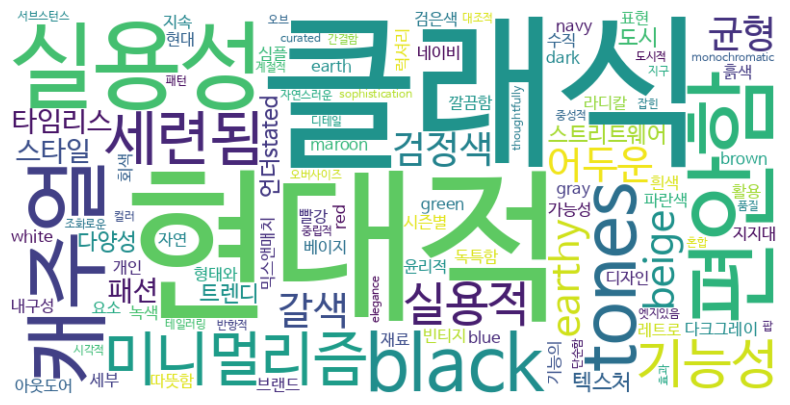

In [34]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [38]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url: {row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트렌드 방향의 분석 보고서를 작성해주세요. 보고서의 제목은 해외 룩복 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서 형식은 markdown 방식으로 해주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text


Processed prompts: 100%|██████████| 2/2 [00:21<00:00, 10.85s/it, est. speed input: 247.84 toks/s, output: 75.45 toks/s]


In [39]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

### 종합적인 패션 트렌드 분석 보고서

#### **1. 개요**
최근 패션 트렌드는 다양성과 실용성을 중심으로 진화하고 있으며, 다양한 스타일 요소가 융합되어 새로운 형태를 창출하고 있습니다. 주어진 이미지들을 통해 관찰된 주요 트렌드와 그 특징들을 종합적으로 분석하였습니다.

#### **2. 주요 트렌드 요소**

**a. 미니멀리즘과 현대성**
- **스타일 예시**: 
  - **이미지 1**: 어두운 회색의 심플한 정장과 오버사이즈 블레이저는 미니멀리즘과 현대적 세련됨을 동시에 표현합니다.
  - **이미지 3**: 베이지와 레드 컬러의 빈티지한 스니커즈는 클래식과 현대적 감각을 결합합니다.
  - **이미지 5**: 브라운과 화이트의 조화로운 조합은 단순하면서도 세련된 캐주얼 스타일을 보여줍니다.
  - **이미지 7**: 검은색 블레이저와 흰색 셔츠의 조합은 클래식한 형태에 현대적인 편안함을 더합니다.

**b. 실용성과 스타일의 융합**
- **스타일 예시**:
  - **이미지 2**: 오버사이즈 데님 셔츠와 롤업 슬리브는 편안함과 스타일을 동시에 추구합니다.
  - **이미지 4**: 브라운 파크카와 다크 코트는 기능성과 고급스러움을 결합한 현대적인 캐주얼 룩을 제시합니다.
  - **이미지 6**: 오버사이즈 블레이저와 흰색 셔츠는 실용성과 세련됨을 동시에 제공합니다.
  - **이미지 8**: 브라운 가죽 재킷과 스트라이프 셔츠는 클래식한 요소와 현대적인 디테일의 조화를 보여줍니다.

**c. 자연스러운 색상과 소재**
- **스타일 예시**:
  - **이미지 1**: 녹색 후드티와 데님 셔츠는 자연스러운 색상 팔레트를 활용합니다.
  - **이미지 3**: 베이지와 블랙의 조화는 계절에 상관없이 착용 가능한 유연성을 제공합니다.
  - **이미지 5**: 브라운과 화이트의 조합은 계절적 제약 없이 다양한 상황에 적합합니다.
  - **이미지 7**: 블랙 블레이저와 화이트 셔츠는 자연스러운 색상과 클래식한 패턴의 균형을 이룹니다.

**d. 기능성과 개성의 조화**
- **스타일 예시**:
  - **이미지 2**: 오버사이즈 데님과 플랫 슈즈는 편안함과 캐주얼한 분위기를 동시에 제공합니다.
  - **이미지 4**: 브라운 파크카와 다크 코트는 실용성과 고급스러움을 결합합니다.
  - **이미지 6**: 오버사이즈 블레이저와 흰색 셔츠는 편안함과 세련됨을 동시에 추구합니다.
  - **이미지 8**: 가죽 재킷과 스트라이프 셔츠는 클래식한 요소와 현대적인 디테일의 조화를 보여줍니다.

#### **3. 결론**
현재 패션 트렌드는 다음과 같은 핵심 요소들을 중심으로 발전하고 있습니다:
- **미니멀리즘과 현대성의 융합**: 심플하면서도 세련된 디자인 요소의 중요성 강조.
- **실용성과 스타일의 균형**: 편안함과 기능성을 유지하면서도 스타일리시한 룩을 추구하는 경향.
- **자연스러운 색상과 소재**: 자연스러운 톤과 소재의 활용으로 계절적 제약 없이 다양한 상황에 적합한 의류 선택.
- **개성과 기능성의 조화**: 개성적인 요소와 실용적인 기능을 동시에 갖춘 디자인의 중요성.

이러한 트렌드는 소비자들이 편안함과 스타일을 동시에 추구하며, 다양한 상황에 유연하게 대응할 수 있는 의류를 선호하는 경향을 반영하고 있습니다. 앞으로도 이러한 균형 잡힌 접근법은 패션 산업에서 지속적으로 중요한 역할을 할 것으로 예상됩니다.